In [45]:
import sys
from pathlib import Path
import pandas as pd

# Notebook cell
%load_ext autoreload
%autoreload 2

# Get root directory (assuming notebook is in root/notebooks/)
NOTEBOOK_DIR = Path.cwd()
ROOT_DIR = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == 'notebooks' else NOTEBOOK_DIR

# Add src directory to Python path
sys.path.append(str(ROOT_DIR / 'src'))

# Verify path
print(f"Python will look in these locations:\n{sys.path}")


# --- Execute the processor ---
import utils


target_date_path, _ = utils.main_processor(
    data_dir='..\picks',  # search project ..\data
    downloads_dir=None,  # None searchs Downloads dir, '' omits search1
    downloads_limit=60,  # search the first 10 files
    clean_name_override=None,  # override filename
    start_file_pattern='2025-', # search for files starting with 'df_'
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python will look in these locations:
['C:\\Users\\ping\\.pyenv\\pyenv-win\\versions\\3.11.9\\python311.zip', 'C:\\Users\\ping\\.pyenv\\pyenv-win\\versions\\3.11.9\\DLLs', 'C:\\Users\\ping\\.pyenv\\pyenv-win\\versions\\3.11.9\\Lib', 'C:\\Users\\ping\\.pyenv\\pyenv-win\\versions\\3.11.9', 'c:\\Users\\ping\\Files_win10\\python\\py311\\.venv', '', 'c:\\Users\\ping\\Files_win10\\python\\py311\\.venv\\Lib\\site-packages', 'c:\\Users\\ping\\Files_win10\\python\\py311\\.venv\\Lib\\site-packages\\win32', 'c:\\Users\\ping\\Files_win10\\python\\py311\\.venv\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\ping\\Files_win10\\python\\py311\\.venv\\Lib\\site-packages\\Pythonwin', 'c:\\Users\\ping\\Files_win10\\python\\py311\\stocks\\src', 'c:\\Users\\ping\\Files_win10\\python\\py311\\.venv\\Lib\\site-packages\\setuptools\\_vendor', 'c:\\Users\\ping\\Files_win10\\python\\py311\\stocks\\src', 'c:\\Users\\ping\\Files_w

<span style='color:#00ffff;font-weight:500'>[Downloads] Scanned latest 60 files • Found 0 '2025-' matches</span>

**Available '2025-' files:**

- (1) `[DATA]` `2025-04-01_cluster_stats_df.parquet` <span style='color:#00ffff'>(0.01 MB, 2025-04-02 09:43)</span>

- (2) `[DATA]` `2025-04-01_detailed_clusters_df.parquet` <span style='color:#00ffff'>(0.05 MB, 2025-04-02 09:43)</span>

- (3) `[DATA]` `2025-04-01_portf.txt` <span style='color:#00ffff'>(0.10 MB, 2025-04-02 09:43)</span>

- (4) `[DATA]` `2025-04-01_selected_stocks.parquet` <span style='color:#00ffff'>(0.03 MB, 2025-04-02 09:43)</span>

- (5) `[DATA]` `2025-04-01_selected_stocks.tsv` <span style='color:#00ffff'>(0.01 MB, 2025-04-02 09:43)</span>

- (6) `[DATA]` `2025-04-02_cluster_stats_df.parquet` <span style='color:#00ffff'>(0.01 MB, 2025-04-02 16:36)</span>

- (7) `[DATA]` `2025-04-02_detailed_clusters_df.parquet` <span style='color:#00ffff'>(0.05 MB, 2025-04-02 16:36)</span>

- (8) `[DATA]` `2025-04-02_portf.txt` <span style='color:#00ffff'>(0.10 MB, 2025-04-02 16:36)</span>

- (9) `[DATA]` `2025-04-02_selected_stocks.parquet` <span style='color:#00ffff'>(0.03 MB, 2025-04-02 16:36)</span>

- (10) `[DATA]` `2025-04-02_selected_stocks.tsv` <span style='color:#00ffff'>(0.01 MB, 2025-04-02 16:36)</span>


Input a number to select file (1-10)



    **Selected paths:**
    - Source: `..\picks\2025-04-02_selected_stocks.parquet`  
    - Destination: `..\picks\2025-04-02_selected_stocks_clean.parquet`
    

In [46]:
target_date = utils.extract_date_from_string(target_date_path)
print(f'target_date: {target_date}')

target_date: 2025-04-02


In [47]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from datetime import datetime, timedelta

def get_nyse_trading_date(date_str, delta_days=0):
    """
    Get NYSE trading date relative to the input date.
    
    Args:
        date_str (str): Date in 'YYYY-MM-DD' format
        delta_days (int): Number of trading days to offset
                          (positive for future, negative for past)
    
    Returns:
        str: Trading date in 'YYYY-MM-DD' format
    """
    # Convert input string to datetime
    date = datetime.strptime(date_str, '%Y-%m-%d').date()
    
    # Create calendar for NYSE business days
    cal = USFederalHolidayCalendar()
    nyse_holidays = cal.holidays(start='2000-01-01', end='2030-12-31').date
    
    # Handle delta_days = 0 case
    if delta_days == 0:
        return date.strftime('%Y-%m-%d')
    
    # Determine direction (1 for forward, -1 for backward)
    direction = 1 if delta_days > 0 else -1
    remaining_days = abs(delta_days)
    current_date = date
    
    while remaining_days > 0:
        # Move one day in the specified direction
        current_date += timedelta(days=direction)
        
        # Check if it's a trading day (weekday and not holiday)
        if current_date.weekday() < 5 and current_date not in nyse_holidays:
            remaining_days -= 1
    
    return current_date.strftime('%Y-%m-%d')


In [48]:
import os
from datetime import datetime

def update_picks_filepath(target_date_path, delta_days=-1):
    """
    Update the date in a file path to the specified trading day offset.
    
    Args:
        target_date_path (str): Original file path containing a date (e.g., '..\picks\2025-04-02_selected_stocks.parquet')
        delta_days (int): Number of trading days to offset (default -1 for previous trading day)
    
    Returns:
        str: Updated file path with new trading date
    """
    # Extract date from source path
    filename = os.path.basename(target_date_path)
    date_str = filename.split('_')[0]  # Gets '2025-04-02' from '2025-04-02_selected_stocks.parquet'
    
    try:
        # Validate date format
        datetime.strptime(date_str, '%Y-%m-%d')
    except ValueError:
        raise ValueError(f"Source path '{target_date_path}' doesn't contain a valid YYYY-MM-DD date")
    
    # Get adjusted trading date
    new_date = get_nyse_trading_date(date_str, delta_days)
    
    # Replace date in path while preserving directory structure and filename parts
    dir_path = os.path.dirname(target_date_path)
    remaining_parts = '_'.join(filename.split('_')[1:])  # Gets 'selected_stocks.parquet'
    new_filename = f"{new_date}_{remaining_parts}"
    
    return os.path.join(dir_path, new_filename)


In [49]:
print(f'target_date_path: {target_date_path}')

previous_trading_day_path = update_picks_filepath(target_date_path, -1)
print(f"previous_trading_day_path: {previous_trading_day_path}")
# Output: ..\picks\2025-04-01_selected_stocks.parquet (assuming 04-01 was the previous trading day)

# You can also use positive deltas
next_trading_day_path = update_picks_filepath(target_date_path, 1)
print(f"next_trading_day_path: {next_trading_day_path}")

target_date_path: ..\picks\2025-04-02_selected_stocks.parquet
previous_trading_day_path: ..\picks\2025-04-01_selected_stocks.parquet
next_trading_day_path: ..\picks\2025-04-03_selected_stocks.parquet


In [50]:
tickers_target_date = pd.read_parquet(target_date_path).index.to_list()
tickers_previous_date = pd.read_parquet(previous_trading_day_path).index.to_list()

print(f'tickers_target_date: {tickers_target_date}')
print(f'tickers_previous_date: {tickers_previous_date}')


tickers_target_date: ['PHYS', 'AM', 'IGF', 'GLD', 'IAU', 'OGE', 'ATO', 'NI', 'EXE']
tickers_previous_date: ['PHYS', 'COR', 'MCK', 'IAU', 'GLDM', 'EPD', 'OGE', 'ATO']


In [ ]:
def compare_tickers(tickers_target_date, tickers_previous_date):
    """
    Compare tickers between target date and previous date.
    
    Args:
        tickers_target_date (list): Tickers on the target date
        tickers_previous_date (list): Tickers on the previous date
    
    Returns:
        dict: {
            'dropped': list of tickers removed from previous date,
            'common': list of tickers present in both dates,
            'added': list of tickers added on target date
        }
    """
    # Convert to sets for efficient comparison
    target_set = set(tickers_target_date)
    previous_set = set(tickers_previous_date)
    
    return {
        'dropped': sorted(list(previous_set - target_set)),  # In previous but not in target
        'common': sorted(list(target_set & previous_set)),   # In both
        'added': sorted(list(target_set - previous_set))     # In target but not in previous
    }

# # Example usage
# tickers_target_date = ['PHYS', 'AM', 'IGF', 'GLD', 'IAU', 'OGE', 'ATO', 'NI', 'EXE']
# tickers_previous_date = ['PHYS', 'COR', 'MCK', 'IAU', 'GLDM', 'EPD', 'OGE', 'ATO']

# result = compare_tickers(tickers_target_date, tickers_previous_date)

# print("Dropped tickers:", result['dropped'])
# print("Common tickers:", result['common'])
# print("Added tickers:", result['added'])

In [ ]:
def compare_tickers_ordered(tickers_target_date, tickers_previous_date):
    """
    Compare tickers between target date and previous date.
    
    Args:
        tickers_target_date (list): Tickers on the target date
        tickers_previous_date (list): Tickers on the previous date
    
    Returns:
        dict: {
            'dropped': list of tickers removed from previous date,
            'common': list of tickers present in both dates,
            'added': list of tickers added on target date
        }
    """    
    target_set = set(tickers_target_date)
    previous_set = set(tickers_previous_date)
    
    return {
        'dropped': [t for t in tickers_previous_date if t not in target_set],  # In previous but not in target
        'common': [t for t in tickers_target_date if t in previous_set],       # In both
        'added': [t for t in tickers_target_date if t not in previous_set]     # In target but not in previous
    }

In [55]:
result = compare_tickers_ordered(tickers_target_date, tickers_previous_date)

print(f'target_date: {target_date}')

print(f'\ntickers_previous_date: {tickers_previous_date}')
print(f'tickers_target_date: {tickers_target_date}')

print(f"\nDropped tickers:", result['dropped'])
print("Common tickers:", result['common'])
print("Added tickers:", result['added'])

target_date: 2025-04-02

tickers_previous_date: ['PHYS', 'COR', 'MCK', 'IAU', 'GLDM', 'EPD', 'OGE', 'ATO']
tickers_target_date: ['PHYS', 'AM', 'IGF', 'GLD', 'IAU', 'OGE', 'ATO', 'NI', 'EXE']

Dropped tickers: ['COR', 'MCK', 'GLDM', 'EPD']
Common tickers: ['PHYS', 'IAU', 'OGE', 'ATO']
Added tickers: ['AM', 'IGF', 'GLD', 'NI', 'EXE']


In [57]:
target_date = utils.extract_date_from_string(target_date_path)
print(f'target_date: {target_date}')

target_date: 2025-04-02


In [ ]:
_df = pd.read_parquet(target_date_path)
_df = _df["Weight"]
print((f'_df {type(_df)}: {_df}'))
_df.info()

In [62]:
import pandas as pd
from datetime import datetime

# Sample data
data = {
    '2025-01-01': {
        'Tickers': ['SPY', 'GLD', 'NVDA'],
        'Weights': [0.5, 0.3, 0.2]
    },
    # You can add more dates here
    '2025-01-08': {
        'Tickers': ['SPY', 'GLD', 'NVDA', 'AAPL'],
        'Weights': [0.4, 0.3, 0.2, 0.1]
    }
}

# Create DataFrame
df = pd.DataFrame.from_dict(data, orient='index')

# Convert index to datetime
df.index = pd.to_datetime(df.index)

# Display the DataFrame
print(df)

                           Tickers               Weights
2025-01-01        [SPY, GLD, NVDA]       [0.5, 0.3, 0.2]
2025-01-08  [SPY, GLD, NVDA, AAPL]  [0.4, 0.3, 0.2, 0.1]


In [67]:
# Adding a new date entry
new_date = '2025-01-15'
df.loc[pd.to_datetime(new_date)] = {
    'Tickers': ['SPY', 'MSFT', 'TSLA', 'APPL'],
    'Weights': [0.6, 0.2, 0.1, 0.1]
}

In [68]:
df

,Tickers,Weights
2025-01-01,"[SPY, GLD, NVDA]","[0.5, 0.3, 0.2]"
2025-01-08,"[SPY, GLD, NVDA, AAPL]","[0.4, 0.3, 0.2, 0.1]"
2025-01-15,"[SPY, MSFT, TSLA, APPL]","[0.6, 0.2, 0.1, 0.1]"


In [ ]:
def calculate_daily_return(row, daily_returns_data):
    tickers = row['Tickers']
    weights = row['Weights']
    date = row.name  # index is the date
    
    # Get returns for each ticker on this date
    ticker_returns = [daily_returns_data.loc[date, t] for t in tickers]
    
    # Calculate weighted return
    return sum(r*w for r, w in zip(ticker_returns, weights))

# Apply to each row
df['Daily_Return'] = df.apply(calculate_daily_return, axis=1, args=(daily_returns_data,))

In [70]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)

## 1. Create the portfolio DataFrame with holdings
portfolio_data = {
    '2025-01-01': {
        'Tickers': ['SPY', 'GLD', 'NVDA'],
        'Weights': [0.5, 0.3, 0.2]
    },
    '2025-01-08': {
        'Tickers': ['SPY', 'GLD', 'NVDA', 'AAPL'],
        'Weights': [0.4, 0.3, 0.2, 0.1]
    },
    '2025-01-15': {
        'Tickers': ['SPY', 'MSFT', 'TSLA'],
        'Weights': [0.6, 0.2, 0.2]
    }
}

portfolio_df = pd.DataFrame.from_dict(portfolio_data, orient='index')
portfolio_df.index = pd.to_datetime(portfolio_df.index)

## 2. Create sample daily returns data for all tickers
tickers = ['SPY', 'GLD', 'NVDA', 'AAPL', 'MSFT', 'TSLA']
dates = pd.date_range(start='2025-01-01', end='2025-01-20')

# Generate random daily returns between -2% and +2%
returns_data = np.random.uniform(-0.02, 0.02, size=(len(dates), len(tickers)))
daily_returns = pd.DataFrame(returns_data, index=dates, columns=tickers)

# Format as percentages for better display
daily_returns = daily_returns.applymap(lambda x: round(x, 4))

## 3. Calculate portfolio daily returns
def calculate_portfolio_return(row):
    date = row.name
    tickers = row['Tickers']
    weights = row['Weights']
    
    # Get returns for each ticker on this date
    try:
        daily_rets = [daily_returns.loc[date, t] for t in tickers]
    except KeyError:
        # If market was closed (no data), return NaN
        return np.nan
    
    # Calculate weighted return
    return sum(r*w for r, w in zip(daily_rets, weights))

# Apply to each row to get daily returns
portfolio_df['Daily_Return'] = portfolio_df.apply(calculate_portfolio_return, axis=1)

## 4. Calculate cumulative performance
portfolio_df['Cumulative_Return'] = (1 + portfolio_df['Daily_Return']).cumprod() - 1

## Display results
print("=== Sample Daily Returns Data (First 5 Days) ===")
print(daily_returns.head())
print("\n=== Portfolio Holdings and Performance ===")
print(portfolio_df)

=== Sample Daily Returns Data (First 5 Days) ===
               SPY     GLD    NVDA    AAPL    MSFT    TSLA
2025-01-01 -0.0050  0.0180  0.0093  0.0039 -0.0138 -0.0138
2025-01-02 -0.0177  0.0146  0.0040  0.0083 -0.0192  0.0188
2025-01-03  0.0133 -0.0115 -0.0127 -0.0127 -0.0078  0.0010
2025-01-04 -0.0027 -0.0084  0.0045 -0.0144 -0.0083 -0.0053
2025-01-05 -0.0018  0.0114 -0.0120  0.0006  0.0037 -0.0181

=== Portfolio Holdings and Performance ===
                           Tickers               Weights  Daily_Return  \
2025-01-01        [SPY, GLD, NVDA]       [0.5, 0.3, 0.2]       0.00476   
2025-01-08  [SPY, GLD, NVDA, AAPL]  [0.4, 0.3, 0.2, 0.1]      -0.00379   
2025-01-15       [SPY, MSFT, TSLA]       [0.6, 0.2, 0.2]      -0.00168   

            Cumulative_Return  
2025-01-01           0.004760  
2025-01-08           0.000952  
2025-01-15          -0.000730  


C:\Users\ping\AppData\Local\Temp\ipykernel_648\3791281266.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  daily_returns = daily_returns.applymap(lambda x: round(x, 4))


=== Sample Daily Returns Data (First 5 Days) ===
               SPY     GLD    NVDA    AAPL    MSFT    TSLA
2025-01-01  0.0075  0.0039  0.0201  0.0054  0.0039  0.0302
2025-01-02 -0.0025  0.0033  0.0162 -0.0028  0.0090  0.0229
2025-01-03 -0.0043  0.0019  0.0076 -0.0007  0.0000  0.0175
2025-01-06 -0.0076  0.0004  0.0074  0.0007  0.0026  0.0143
2025-01-07 -0.0039 -0.0044  0.0142  0.0005  0.0117  0.0060

=== Portfolio Performance ===
            Portfolio_Return  Cumulative_Return
2025-01-01           0.00894           0.008940
2025-01-02           0.00298           0.011947
2025-01-03          -0.00006           0.011886
2025-01-06          -0.00220           0.009660
2025-01-07          -0.00043           0.009226
2025-01-08          -0.00244           0.006763
2025-01-09          -0.00349           0.003250
2025-01-10          -0.00208           0.001163
2025-01-13          -0.00069           0.000472
2025-01-14          -0.00231          -0.001839
2025-01-15          -0.00532          

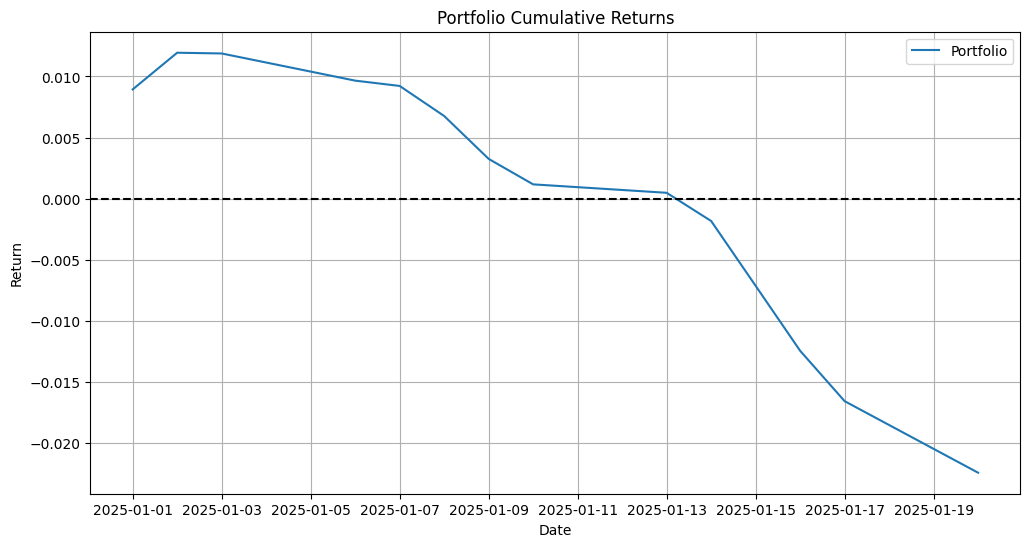

In [73]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# 1. Create the portfolio DataFrame with holdings
portfolio_data = {
    '2025-01-01': {
        'Tickers': ['SPY', 'GLD', 'NVDA'],
        'Weights': [0.5, 0.3, 0.2]
    },
    '2025-01-08': {
        'Tickers': ['SPY', 'GLD', 'NVDA', 'AAPL'],
        'Weights': [0.4, 0.3, 0.2, 0.1]
    },
    '2025-01-15': {
        'Tickers': ['SPY', 'MSFT', 'TSLA'],
        'Weights': [0.6, 0.2, 0.2]
    }
}

portfolio_df = pd.DataFrame.from_dict(portfolio_data, orient='index')
portfolio_df.index = pd.to_datetime(portfolio_df.index)

# 2. Create more realistic daily returns data
tickers = ['SPY', 'GLD', 'NVDA', 'AAPL', 'MSFT', 'TSLA']
all_dates = pd.date_range(start='2025-01-01', end='2025-01-20')

# Remove weekends (market closed)
business_days = all_dates[all_dates.dayofweek < 5]

def generate_returns(dates, assets):
    base_vol = 0.015  # 1.5% daily volatility
    returns = pd.DataFrame(index=dates, columns=assets)
    
    for asset in assets:
        # Random walk with some serial correlation
        shocks = np.random.normal(0, base_vol, len(dates))
        for i in range(1, len(dates)):
            shocks[i] = 0.7*shocks[i-1] + 0.3*np.random.normal(0, base_vol)
        
        # Add some asset-specific characteristics
        if asset == 'GLD':
            shocks *= 0.7  # Gold is less volatile
        elif asset in ['NVDA', 'TSLA']:
            shocks *= 1.3  # Tech stocks more volatile
            
        returns[asset] = shocks
        
    return returns.round(4)

daily_returns = generate_returns(business_days, tickers)

# 3. Calculate portfolio daily returns for ALL days
performance_df = pd.DataFrame(index=business_days)
performance_df['Portfolio_Return'] = np.nan

# Forward fill the holdings between rebalance dates
current_holdings = None
current_weights = None

for date in business_days:
    try:
        if date in portfolio_df.index:
            # Update holdings on rebalance dates
            current_holdings = portfolio_df.loc[date, 'Tickers']
            current_weights = portfolio_df.loc[date, 'Weights']
        
        if current_holdings is not None:
            # Get returns for current holdings
            day_returns = [daily_returns.loc[date, t] for t in current_holdings]
            # Calculate weighted return
            performance_df.loc[date, 'Portfolio_Return'] = sum(r*w for r, w in zip(day_returns, current_weights))
    except Exception as e:
        print(f"Error processing date {date}: {str(e)}")
        continue

# 4. Calculate cumulative performance
performance_df['Cumulative_Return'] = (1 + performance_df['Portfolio_Return']).cumprod() - 1

# 5. Merge with original portfolio data
full_df = pd.merge(portfolio_df, performance_df, left_index=True, right_index=True, how='outer')

# Display results
print("=== Sample Daily Returns Data (First 5 Days) ===")
print(daily_returns.head())
print("\n=== Portfolio Performance ===")
print(performance_df[['Portfolio_Return', 'Cumulative_Return']].dropna())

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(performance_df.index, performance_df['Cumulative_Return'], label='Portfolio')
plt.title('Portfolio Cumulative Returns')
plt.ylabel('Return')
plt.xlabel('Date')
plt.grid(True)
plt.axhline(0, color='black', linestyle='--')
plt.legend()
plt.show()